## Visualising time-series

We visualise the time-series to get a better idea of the characteristics of our interlinkages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import pairwise_kernels, pairwise_distances
from sklearn.decomposition import PCA, KernelPCA, FastICA
import seaborn as sns
import dcor
from scipy.stats import pearsonr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, Exponentiation, DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
import numpy.polynomial.polynomial as poly
import warnings 
warnings.filterwarnings('ignore')

In [2]:
indicators_values_i = pickle.load(open('utils/data/indicators_values_i_up_wb.pkl', 'rb'))
targets_values_i = pickle.load(open('utils/data/targets_values_i_up_arr_wb.pkl', 'rb'))
goals_values_i = pickle.load(open('utils/data/goals_values_i_up_arr_wb.pkl', 'rb'))
dict_all = pickle.load(open('utils/data/dict_all_wb.pkl', 'rb'))
dict_all_std = pickle.load(open('utils/data/dict_all_wb_std.pkl', 'rb'))
dict_all_i = pickle.load(open('utils/data/dict_all_i_wb.pkl', 'rb'))
averages = pickle.load(open('distance_cor/goals/grouping_averages.pkl', 'rb'))
dict_t = pickle.load(open('utils/data/temp.pkl', 'rb'))

In [3]:
# read amended csv file
c = pd.read_csv('utils/countries_wb.csv', dtype=str, delimiter=';', header=None)
countries = list(c[0])
continents = pd.read_csv(r'utils/continents.csv')
continents.replace({"Democratic People's Republic of Korea": "Korea, Dem. People's Rep.", 'Gambia': 'Gambia, The', 'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom', 'Congo': 'Congo, Rep.', 'Democratic Republic of the Congo': 'Congo, Dem. Rep.', 'Czechia': 'Czech Republic', 'Iran (Islamic Republic of)': 'Iran, Islamic Rep.', "Côte d'Ivoire": "Cote d'Ivoire", 'Kyrgyzstan': 'Kyrgyz Republic', "Lao People's Democratic Republic": 'Lao PDR', 'Republic of Moldova': 'Moldova', 'Micronesia (Federated States of)': 'Micronesia, Fed. Sts.', 'Slovakia': 'Slovak Republic', 'Viet Nam': 'Vietnam', 'Egypt': 'Egypt, Arab Rep.', 'United Republic of Tanzania': 'Tanzania','United States of America': 'United States', 'Venezuela (Bolivarian Republic of)': 'Venezuela, RB', 'Yemen': 'Yemen, Rep.', 'Bahamas': 'Bahamas, The', 'Bolivia (Plurinational State of)': 'Bolivia'}, inplace=True)
groups = pd.read_csv(r'utils/groups.csv')
groups.replace({"Democratic People's Republic of Korea": "Korea, Dem. People's Rep.", 'Gambia': 'Gambia, The', 'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom', 'Congo': 'Congo, Rep.', 'Democratic Republic of the Congo': 'Congo, Dem. Rep.', 'Czechia': 'Czech Republic', 'Iran (Islamic Republic of)': 'Iran, Islamic Rep.', "Côte d'Ivoire": "Cote d'Ivoire", 'Kyrgyzstan': 'Kyrgyz Republic', "Lao People's Democratic Republic": 'Lao PDR', 'Republic of Moldova': 'Moldova', 'Micronesia (Federated States of)': 'Micronesia, Fed. Sts.', 'Slovakia': 'Slovak Republic', 'Viet Nam': 'Vietnam', 'Egypt': 'Egypt, Arab Rep.', 'United Republic of Tanzania': 'Tanzania','United States of America': 'United States', 'Venezuela (Bolivarian Republic of)': 'Venezuela, RB', 'Yemen': 'Yemen, Rep.', 'Bahamas': 'Bahamas, The', 'Bolivia (Plurinational State of)': 'Bolivia'}, inplace=True)
info = pd.read_csv(r'utils/wb_info.csv', header=None)
period = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

In [4]:
# removes key in-place
countries.remove('Micronesia, Fed. Sts.')
continents['Oceania (excl. AUS + NZ)'] = continents['Oceania (excl. AUS + NZ)'].drop(index=4)
continents['Oceania (incl. AUS + NZ)'] = continents['Oceania (incl. AUS + NZ)'].drop(index=6)
continents['World'] = continents['World'].drop(index=170)
groups['Global South'].drop(index=1, inplace=True)

In [5]:
for country in countries:
    dict_t[country].set_index('YEAR', inplace=True)
    dict_t[country].index = dict_t[country].index.astype(str)
    dict_all_std[country] = dict_all_std[country].append(dict_t[country].AVG[-len(period):])
    dict_all_std[country].rename({'AVG': 'Temperature'}, inplace=True)
    dict_all[country] = dict_all[country].append(dict_t[country].AVG[-len(period):])
    dict_all[country].rename({'AVG': 'Temperature'}, inplace=True)

In [6]:
indicators = list(dict_all['France'].index)

In [7]:
targets = list(info[4].unique())

dict_targets = {}

for target in targets:
    t = info[0].where(info[4] == target)

    dict_targets[target] = [i for i in t if str(i) != 'nan']

In [8]:
#check 
dict_targets['7.1']

['EG.CFT.ACCS.ZS', 'EG.ELC.ACCS.RU.ZS', 'EG.ELC.ACCS.UR.ZS', 'EG.ELC.ACCS.ZS']

In [9]:
goals = list(info[3].unique())

dict_goals = {}

for goal in goals:
    g = info[4].where(info[3] == goal)

    dict_goals[goal] = [t for t in g if str(t) != 'nan']
    dict_goals[goal] = list(set(dict_goals[goal]))

Defining combinations of goals:

In [10]:
def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield list(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield list(pool[i] for i in indices)

In [11]:
g_combinations = list(combinations(goals, 2))
pairs_g1 = pd.DataFrame.from_records(data=g_combinations, columns=['pair_0', 'pair_1'])

In [12]:
# data preparation for continents (goals)
continents_prep_g = {}

for continent in continents:
    print(continent)
    
    continents_prep_g[continent] = np.empty(18, dtype=object)
    
    for g, goal in enumerate(goals):
        g_list = []
        for country in continents[continent].dropna():
            g_list.append(np.asarray(goals_values_i[country][g]))

        continents_prep_g[continent][g] = np.asarray(g_list)

Northern Africa
Eastern Africa
Middle Africa
Southern Africa
Western Africa
Sub-Saharan Africa
Africa
Caribbean
Central America
South America
Latin America and the Caribbean
North America
Americas
Central and Eastern Asia
South-eastern Asia
Southern Asia
Western Asia
Asia
Eastern Europe
Northern Europe
Southern Europe
Western Europe
Europe
Australia and New Zealand
Oceania (excl. AUS + NZ)
Oceania (incl. AUS + NZ)
World


In [13]:
# data preparation for continents (indicators)
continents_prep_i = {}

for continent in continents:
    print(continent)
    
    continents_prep_i[continent] = np.empty(len(dict_all['France']), dtype=object)
    
    for i, ind in enumerate(list(dict_all['France'].index)):
        i_list = []
        for country in continents[continent].dropna():
            i_list.append(np.asarray(dict_all[country].iloc[i].dropna()))

        continents_prep_i[continent][i] = np.asarray(i_list)

Northern Africa
Eastern Africa
Middle Africa
Southern Africa
Western Africa
Sub-Saharan Africa
Africa
Caribbean
Central America
South America
Latin America and the Caribbean
North America
Americas
Central and Eastern Asia
South-eastern Asia
Southern Asia
Western Asia
Asia
Eastern Europe
Northern Europe
Southern Europe
Western Europe
Europe
Australia and New Zealand
Oceania (excl. AUS + NZ)
Oceania (incl. AUS + NZ)
World


In [14]:
# data preparation for groups (goals)
groups_prep_g = {}

for group in groups:
    print(group)
    
    groups_prep_g[group] = np.empty(18, dtype=object)
    
    for g, goal in enumerate(goals):
        g_list = []
        for country in groups[group].dropna():
            g_list.append(np.asarray(goals_values_i[country][g]))

        groups_prep_g[group][g] = np.asarray(g_list)

Global North
Global South
Least Developed Countries (LDC)
Land Locked Developing Countries (LLDC)
Small Island Developing States (SIDS)
G20
Emerging Markets (BRICS + N-11)
OPEC
Low Income
Lower middle Income
Upper middle Income
High Income


In [15]:
# data preparation for groups (indicators)
groups_prep_i = {}

for group in groups:
    print(group)
    
    groups_prep_i[group] = np.empty(len(dict_all['France']), dtype=object)
    
    for i, ind in enumerate(list(dict_all['France'].index)):
        i_list = []
        for country in groups[group].dropna():
            i_list.append(np.asarray(dict_all[country].iloc[i].dropna()))

        groups_prep_i[group][i] = np.asarray(i_list)

Global North
Global South
Least Developed Countries (LDC)
Land Locked Developing Countries (LLDC)
Small Island Developing States (SIDS)
G20
Emerging Markets (BRICS + N-11)
OPEC
Low Income
Lower middle Income
Upper middle Income
High Income


In [16]:
# confidence intervals
def confidence(mean):
    interval = np.sqrt((mean * (100 - mean)) / 100)
    return interval

def width(Z):
    """
    Computes the median heuristic for the kernel bandwidth
    """
    dist_mat = pairwise_distances(Z, metric='euclidean')
    width_Z = np.median(dist_mat[dist_mat > 0])
    return width_Z

### Visualising dependence between nodes without the influence of the conditional sets
We visualise the relationship between any two distance correlated nodes without the influence of the conditional set. We do so by regressing the conditional set $Z$ on both variables $X$ and $Y$ (with kernel ridge regression), and computing the residuals $r_x = x - f(z)$, and $r_y = y - f(z)$.

Then, we regress $r_y$ on $r_x$ to have a projection of $r_y$ onto the space of $r_x$. Finally, we plot this projection and $r_x$ to examine the relationship between $X$ and $Y$ visually.

In [17]:
# representatives
HI = pd.read_csv('distance_cor/distances_average_High Income.csv', index_col=[0], names=['country', 'distance'], skiprows=[0])
HI_rep = HI.iloc[0]
UMI = pd.read_csv('distance_cor/distances_average_Upper middle Income.csv', index_col=[0], names=['country', 'distance'], skiprows=[0])
UMI_rep = UMI.iloc[0]
LMI = pd.read_csv('distance_cor/distances_average_Lower middle Income.csv', index_col=[0], names=['country', 'distance'], skiprows=[0])
LMI_rep = LMI.iloc[0]
LI = pd.read_csv('distance_cor/distances_average_Low Income.csv', index_col=[0], names=['country', 'distance'], skiprows=[0])
LI_rep = LI.iloc[0]
print(HI_rep.country)
print(UMI_rep.country)
print(LMI_rep.country)
print(LI_rep.country)

Belgium
Turkmenistan
Kiribati
Somalia


In [18]:
# conditions
HI_cond = pd.read_csv('distance_cor/goals/conditions_High Income.csv', index_col=[0])
UMI_cond = pd.read_csv('distance_cor/goals/conditions_Upper middle Income.csv', index_col=[0])
LMI_cond = pd.read_csv('distance_cor/goals/conditions_Lower middle Income.csv', index_col=[0])
LI_cond = pd.read_csv('distance_cor/goals/conditions_Low Income.csv', index_col=[0])
LAC_cond = pd.read_csv('distance_cor/goals/conditions_Latin America and the Caribbean.csv', index_col=[0])

In [19]:
# example: SDG 8 and 17 in High Income
HI_8_17 = HI_cond.loc[(HI_cond['pair_0']==8) & (HI_cond['pair_1']=='17')]
HI_8_17

,pair_0,pair_1,min_dcor,p-value,condition
106,8,17,0.12478,0.0001,"('1', '2', '3', '5', '7', '9', '10', '11', '12..."


## Comparison of dependence before and after regressed on conditional subset

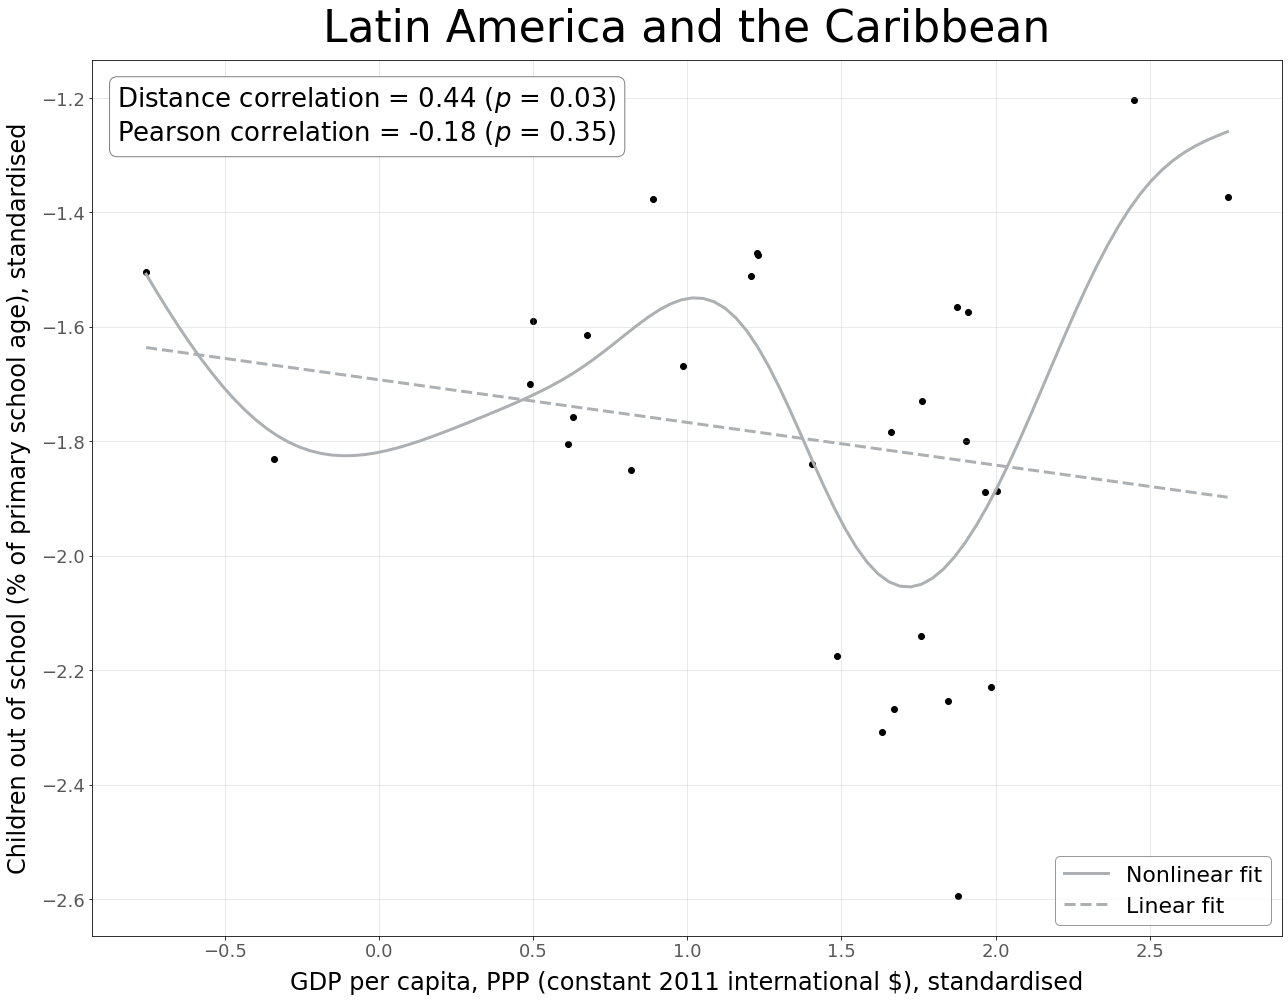

In [196]:
# before
ind_0 = 'NY.GDP.PCAP.PP.KD' 
ind_1 = 'SE.PRM.UNER.ZS' 
group = 'Latin America and the Caribbean'
last_n = 0

x = []
y = []
for country in continents[group].dropna():
#for country in groups[group].dropna():
    if len(dict_all_i[country].loc[ind_0].dropna())>last_n and len(dict_all_i[country].loc[ind_1].dropna())>last_n:
        x.extend(dict_all_i[country].loc[ind_0].dropna().tail(last_n+1).to_list())
        y.extend(dict_all_i[country].loc[ind_1].dropna().tail(last_n+1).to_list())

if len(x)==0 or len(y)==0:
    pass
else:
    x = np.asarray(x).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
    
    d_cor = dcor.distance_correlation(x, y)
    d_cor_test = dcor.independence.distance_covariance_test(x, y, num_resamples=10000)

    p_cor = pearsonr(x.reshape(-1), y.reshape(-1))

    # plot x against y; each country is one data point
    plt.figure(figsize=(18,14))
    plt.scatter(x, y, c='k')
    
    # fitting non-linear function to data
    kernel = Matern(nu=2.5)
    #kernel = RBF(length_scale=1)
    gpr_x = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=0.025)
    gpr_x.fit(x, y)
    x_ = np.linspace(min(x), max(x), 100)
    y_mean_gpr, y_std_gpr = gpr_x.predict(x_, return_std=True)
    
    plt.plot(x_, y_mean_gpr, '#adb0b3', lw=3, ls='-', label='Nonlinear fit')
    
    # fitting linear function to data
    linreg = LinearRegression()
    linreg.fit(x, y)
    y_mean_linreg = linreg.predict(x_)
    plt.plot(x_, y_mean_linreg, '#adb0b3', lw=3, ls='--', label='Linear fit')
    
    plt.xlabel(r'{}, standardised'.format(info[info[0]==ind_0][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.ylabel(r'{}, standardised'.format(info[info[0]==ind_1][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.xticks(size=18, alpha=0.65)
    plt.yticks(size=18, alpha=0.65)
    plt.title('{}'.format(group), y=1.015, fontdict={'fontsize': 44})
    
    textstr = '\n'.join((
        'Distance correlation = %.2f ($p$ = %.2f)' % (d_cor, d_cor_test.p_value),
        'Pearson correlation = %.2f ($p$ = %.2f)' % (p_cor[0], p_cor[1])))
    props = dict(boxstyle='round', facecolor='white', edgecolor='grey')
    plt.text(-0.85, -1.275, textstr, fontsize=26, bbox=props)
    
    plt.grid(alpha=0.35)
    plt.legend(loc=4, fontsize=22, edgecolor='grey')
    plt.tight_layout()
    plt.savefig('distance_cor/conditioning_before.png', format='png')
    plt.show()

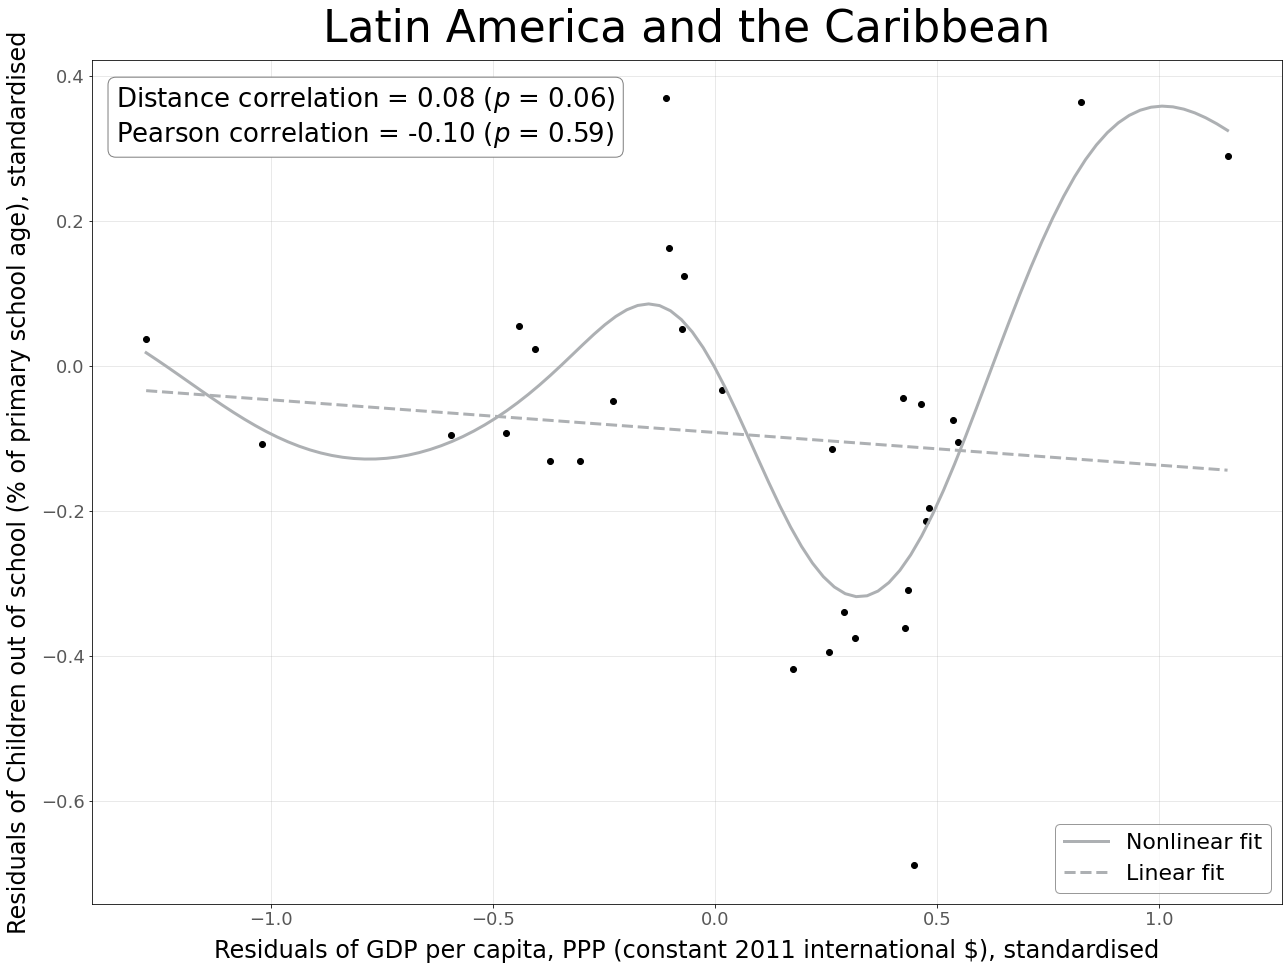

In [210]:
# after
ind_0 = 'NY.GDP.PCAP.PP.KD'
pair_0 = int(info[info[0]==ind_0][3])
ind_1 = 'SE.PRM.UNER.ZS' 
pair_1 = int(info[info[0]==ind_1][3])
group = 'Latin America and the Caribbean'
last_n = 0

LAC_cond['pair_0'] = LAC_cond['pair_0'].astype(str)
if pair_0 > pair_1:
    group_cond = LAC_cond.loc[(LAC_cond['pair_0']=='{}'.format(pair_1)) & (LAC_cond['pair_1']=='{}'.format(pair_0))]
else:
    group_cond = LAC_cond.loc[(LAC_cond['pair_0']=='{}'.format(pair_0)) & (LAC_cond['pair_1']=='{}'.format(pair_1))]

if pair_0=='T':
    #x_res = groups_prep_g[group][17]
    x_res = continents_prep_g[group][17]
else:
    #x_res = groups_prep_g[group][int(pair_0)-1]
    x_res = continents_prep_g[group][int(pair_0)-1]
if pair_1=='T':
    #y_res = groups_prep_g[group][17]
    y_res = continents_prep_g[group][17]
else:
    #y_res = groups_prep_g[group][int(pair_1)-1]
    y_res = continents_prep_g[group][int(pair_1)-1]
    
# extracting conditional variables from column 'condition'
cond_list = []
for i in group_cond.condition.to_list()[0].split():
    newstr = ''.join((ch if ch in '0123456789.-eT' else ' ') for ch in i)
    cond_list.extend([i for i in newstr.split()])

condition = []
for c in cond_list:
    if c=='T':
        #condition.extend(groups_prep_g[group][17].T)
        condition.extend(continents_prep_g[group][17].T)
    else:
        #condition.extend(groups_prep_g[group][int(c)-1].T)
        condition.extend(continents_prep_g[group][int(c)-1].T)

z = np.asarray(condition).T

krr_x = KernelRidge(alpha=1, kernel='rbf', gamma=0.5/(width(z)**2))
krr_y = KernelRidge(alpha=1, kernel='rbf', gamma=0.5/(width(z)**2))
krr_x.fit(z, x_res)
krr_y.fit(z, y_res)

# project z on x and y
z_proj_x_res = krr_x.predict(z)
z_proj_y_res = krr_y.predict(z)

# residuals
r_x = x_res - z_proj_x_res
r_y = y_res - z_proj_y_res

x = []
y = []
for c, country in enumerate(continents[group].dropna()):
#for country in groups[group].dropna():
    k_x = np.where(x_res[c]==indicators_values_i[country].loc[ind_0].tail(last_n+1)[0])[0]
    k_y = np.where(y_res[c]==indicators_values_i[country].loc[ind_1].tail(last_n+1)[0])[0]
    x.extend(r_x[c][k_x])
    y.extend(r_y[c][k_y])

if len(x)==0 or len(y)==0:
    pass
else:
    x = np.asarray(x).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
    
    p_cor = pearsonr(x.reshape(-1), y.reshape(-1))
    
    # dcor only with last measurements
    #d_cor = dcor.partial_distance_correlation(x, y, z)
    #d_cor_test = dcor.independence.partial_distance_covariance_test(x, y, z, num_resamples=10000)
    
    # dcor with entire series
    pair_0_array = continents_prep_g[group][pair_0-1]
    pair_1_array = continents_prep_g[group][pair_1-1]
    d_cor = dcor.partial_distance_correlation(pair_0_array, pair_1_array, z)
    d_cor_test = dcor.independence.partial_distance_covariance_test(pair_0_array, pair_1_array, z, num_resamples=10000)

    # plot x against y; each country is one data point
    plt.figure(figsize=(18,14))
    plt.scatter(x, y, c='k')
    
    # fitting non-linear function to data
    kernel = Matern(nu=2.5)
    #kernel = RBF(length_scale=1)
    gpr_x = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=0.025)
    gpr_x.fit(x, y)
    x_ = np.linspace(min(x), max(x), 100)
    y_mean_gpr, y_std_gpr = gpr_x.predict(x_, return_std=True)
    
    plt.plot(x_, y_mean_gpr, '#adb0b3', lw=3, ls='-', label='Nonlinear fit')
    
    # fitting linear function to data
    linreg = LinearRegression()
    linreg.fit(x, y)
    y_mean_linreg = linreg.predict(x_)
    plt.plot(x_, y_mean_linreg, '#adb0b3', lw=3, ls='--', label='Linear fit')
    
    plt.xlabel(r'Residuals of {}, standardised'.format(info[info[0]==ind_0][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.ylabel(r'Residuals of {}, standardised'.format(info[info[0]==ind_1][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.xticks(size=18, alpha=0.65)
    plt.yticks(size=18, alpha=0.65)
    plt.title('{}'.format(group), y=1.015, fontdict={'fontsize': 44})
    
    textstr = '\n'.join((
        'Distance correlation = %.2f ($p$ = %.2f)' % (d_cor, d_cor_test.p_value),
        'Pearson correlation = %.2f ($p$ = %.2f)' % (p_cor[0], p_cor[1])))
    props = dict(boxstyle='round', facecolor='white', edgecolor='grey')
    plt.text(-1.35, 0.31, textstr, fontsize=26, bbox=props)
    
    plt.grid(alpha=0.35)
    plt.legend(loc=4, fontsize=22, edgecolor='grey')
    plt.tight_layout()
    plt.savefig('distance_cor/conditioning_after.png', format='png')
    plt.show()

## Plotting the first principle components of the residuals of $X$ and $Y$

In [ ]:
def residuals_kpca(pair_0, pair_1, group):
    
    if group=='High Income':
        HI_cond['pair_0'] = HI_cond['pair_0'].astype(str)
        group_cond = HI_cond.loc[(HI_cond['pair_0']=='{}'.format(pair_0)) & (HI_cond['pair_1']=='{}'.format(pair_1))]
    elif group=='Upper middle Income':
        UMI_cond['pair_0'] = UMI_cond['pair_0'].astype(str)
        group_cond = UMI_cond.loc[(UMI_cond['pair_0']=='{}'.format(pair_0)) & (UMI_cond['pair_1']=='{}'.format(pair_1))]
    elif group=='Lower middle Income':
        LMI_cond['pair_0'] = LMI_cond['pair_0'].astype(str)
        group_cond = LMI_cond.loc[(LMI_cond['pair_0']=='{}'.format(pair_0)) & (LMI_cond['pair_1']=='{}'.format(pair_1))]
    elif group=='Low Income':
        LI_cond['pair_0'] = LI_cond['pair_0'].astype(str)
        group_cond = LI_cond.loc[(LI_cond['pair_0']=='{}'.format(pair_0)) & (LI_cond['pair_1']=='{}'.format(pair_1))]
    elif group=='Latin America and the Caribbean':
        LAC_cond['pair_0'] = LAC_cond['pair_0'].astype(str)
        group_cond = LAC_cond.loc[(LAC_cond['pair_0']=='{}'.format(pair_0)) & (LAC_cond['pair_1']=='{}'.format(pair_1))]
    else:
        raise ValueError('Not possible for this group yet.')
    
    if pair_0=='T':
        #x = groups_prep_g[group][17]
        x = continents_prep_g[group][17]
    else:
        #x = groups_prep_g[group][int(pair_0)-1]
        x = continents_prep_g[group][int(pair_0)-1]
        
    if pair_1=='T':
        #y = groups_prep_g[group][17]
        y = continents_prep_g[group][17]
    else:
        #y = groups_prep_g[group][int(pair_1)-1]
        y = continents_prep_g[group][int(pair_0)-1]
    
    # extracting conditional variables from column 'condition'
    cond_list = []
    for i in group_cond.condition.to_list()[0].split():
        newstr = ''.join((ch if ch in '0123456789.-eT' else ' ') for ch in i)
        cond_list.extend([i for i in newstr.split()])

    condition = []
    for c in cond_list:
        if c=='T':
            #condition.extend(groups_prep_g[group][17].T)
            condition.extend(continents_prep_g[group][17].T)
        else:
            #condition.extend(groups_prep_g[group][int(c)-1].T)
            condition.extend(continents_prep_g[group][int(c)-1].T)

    z = np.asarray(condition).T

    krr_x = KernelRidge(alpha=1, kernel='rbf', gamma=0.5/(width(z)**2))
    krr_y = KernelRidge(alpha=1, kernel='rbf', gamma=0.5/(width(z)**2))
    krr_x.fit(z, x)
    krr_y.fit(z, y)
    z_proj_x = krr_x.predict(z)
    z_proj_y = krr_y.predict(z)
    
    # residuals
    r_x = x - z_proj_x
    r_y = y - z_proj_y 
    
    # selecting the principle component of r_y and r_x
    kpca_x = KernelPCA(n_components=1, kernel='rbf')
    kpca_y = KernelPCA(n_components=1, kernel='rbf')
    r_x_kpca = kpca_x.fit_transform(r_x)
    r_y_kpca = kpca_y.fit_transform(r_y)

    # plot r_x_kpca against r_y_kpca; each country is one data point
    plt.figure(figsize=(18,14))
    plt.scatter(r_x_kpca, r_y_kpca, c='k')

    kernel = Matern(nu=2.5)
    gpr_x = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, alpha=1e-2).fit(r_x_kpca, r_y_kpca)
    x_ = np.linspace(min(r_x_kpca), max(r_x_kpca), 100)
    y_mean, y_std = gpr_x.predict(x_, return_std=True)
    
    plt.plot(x_, y_mean, '#adb0b3', lw=3)
    plt.fill_between(x_.flatten(), y_mean.flatten()-1.96*y_std, y_mean.flatten()+1.96*y_std, interpolate=True, alpha=0.25, color='#adb0b3')
    x_label_x = 'SDG {}'.format(pair_0)
    if pair_1=='T':
        y_label_x = 'Mean Temperature'
    else:
        y_label_x = 'SDG {}'.format(pair_1)
    plt.xlabel(r'$1^{st}$ Principle Component of %s' % x_label_x, fontsize=32, labelpad=10)
    plt.ylabel(r'$1^{st}$ Principle Component of %s' % y_label_x, fontsize=32, labelpad=10)
    plt.xticks([])
    plt.yticks([])
    plt.title('{}'.format(group), y=1.015, fontdict={'fontsize': 44})
    plt.show()
    
    return r_x_kpca, r_y_kpca

In [ ]:
# example
r_x_kpca, r_y_kpca = residuals_kpca(4, 17, 'Latin America and the Caribbean')

## Searching for example for Figure 1

In [26]:
def corr(ind_0, ind_1, group, last_n=0):
    x = []
    y = []
    for country in continents[group].dropna():
    #for country in groups[group].dropna():
        if len(dict_all[country].loc[ind_0].dropna())>last_n and len(dict_all[country].loc[ind_1].dropna())>last_n:
            x.extend(dict_all[country].loc[ind_0].dropna().tail(last_n+1).to_list())
            y.extend(dict_all[country].loc[ind_1].dropna().tail(last_n+1).to_list())

    if len(x)<2 or len(y)<2:
        return None
    else:
        x = np.asarray(x).reshape(-1,1)
        y = np.asarray(y).reshape(-1,1)

        d_cor = dcor.distance_correlation(x, y)
        d_cor_test = dcor.independence.distance_covariance_test(x, y, num_resamples=5000)

        p_cor = pearsonr(x.reshape(-1), y.reshape(-1))
        
        return d_cor, d_cor_test.p_value, p_cor[0], p_cor[1]

In [28]:
examples = {}

for group in ['Latin America and the Caribbean']:  #groups.columns.to_list():
    print('----------------------------------------')
    print(group)
    examples[group] = {}
    
    for ind_0 in indicators:
        for ind_1 in indicators:
            if ind_0!=ind_1:
                c = corr(ind_0, ind_1, group)
                if c==None:
                    pass
                elif 0.4<c[0]<1 and c[1]<0.05 and -0.15<c[2]<0.15 and c[3]>0.4:
                    examples[group][(ind_0, ind_1)] = c
                    print(group, ind_0, ind_1, c)
                else:
                    pass

----------------------------------------
Latin America and the Caribbean
Latin America and the Caribbean EG.CFT.ACCS.ZS SE.ADT.1524.LT.FM.ZS (0.4708382488108545, 0.04559088182363527, 0.018072817836142493, 0.930172091775537)
Latin America and the Caribbean EG.CFT.ACCS.ZS SL.UEM.TOTL.MA.NE.ZS (0.4302036944625555, 0.03799240151969606, 0.12311937184559013, 0.5245928167671373)
Latin America and the Caribbean EG.CFT.ACCS.ZS SL.UEM.1524.FE.ZS (0.4428568915887445, 0.04779044191161767, 0.0732430844346381, 0.7221562585979073)
Latin America and the Caribbean EG.CFT.ACCS.ZS SL.UEM.1524.ZS (0.4514128676747611, 0.046790641871625675, 0.13147604945883612, 0.5220318823725022)
Latin America and the Caribbean SP.ADO.TFRT SH.STA.WASH.P5 (0.45434773854742894, 0.016996600679864027, 0.08847991651160464, 0.6543511454778008)
Latin America and the Caribbean SE.SEC.UNER.LO.ZS NY.GDP.PCAP.KD (0.440276143578871, 0.04279144171165767, 0.01610219507004277, 0.933927965174799)
Latin America and the Caribbean SE.SEC.UNE

Latin America and the Caribbean EG.EGY.PRIM.PP.KD IT.NET.USER.ZS (0.4750348700468077, 0.010397920415916816, -0.1272814676716539, 0.5026916716483788)
Latin America and the Caribbean SH.STA.BFED.ZS NY.GDP.MINR.RT.ZS (0.466361571563834, 0.03759248150369926, -0.005912384603409149, 0.9771318989532276)
Latin America and the Caribbean NE.EXP.GNFS.ZS NV.IND.MANF.ZS (0.47052139442073826, 0.016996600679864027, 0.1250732788186603, 0.5179820348348588)
Latin America and the Caribbean IC.FRM.FEMM.ZS NY.GNP.PCAP.KD (0.46033167601862535, 0.04559088182363527, -0.0566256675666843, 0.7790649527712744)
Latin America and the Caribbean IC.FRM.FEMM.ZS NV.IND.EMPL.KD (0.5310994891674269, 0.01979604079184163, -0.07165465759651804, 0.7452584205471885)
Latin America and the Caribbean IC.FRM.FEMM.ZS NV.SRV.EMPL.KD (0.4921582644061892, 0.03979204159168166, -0.047411600653172764, 0.8299089672702439)
Latin America and the Caribbean EN.FSH.THRD.NO EG.ELC.RNEW.ZS (0.43004124810343974, 0.033393321335732855, 0.091058498

Latin America and the Caribbean NV.IND.MANF.ZS SL.UEM.TOTL.MA.ZS (0.4403382287763418, 0.041391721655668866, -0.07190287734378735, 0.7215402652205701)
Latin America and the Caribbean NV.IND.MANF.ZS SL.UEM.TOTL.MA.NE.ZS (0.5760014633587788, 0.0007998400319936012, -0.04535117639021727, 0.8119074517284487)
Latin America and the Caribbean NV.IND.MANF.ZS SL.UEM.1524.MA.ZS (0.4538690051507217, 0.03059388122375525, -0.09515185760363963, 0.6368541846371397)
Latin America and the Caribbean NV.IND.MANF.ZS SL.UEM.1524.MA.NE.ZS (0.5127448861172111, 0.004999000199960008, -0.0828103337016538, 0.6635286662127243)
Latin America and the Caribbean NV.IND.MANF.ZS ER.GDP.FWTL.M3.KD (0.4925411237769098, 0.038592281543691265, 0.0003640518192545572, 0.9985045751883882)
Latin America and the Caribbean NY.GDP.MINR.RT.ZS SH.STA.BFED.ZS (0.466361571563834, 0.041391721655668866, -0.005912384603409149, 0.9771318989532276)
Latin America and the Caribbean SH.STA.TRAF.P5 SE.PRM.OENR.ZS (0.4564467166567326, 0.045190961

Latin America and the Caribbean EG.ELC.RNEW.ZS SH.TBS.INCD (0.49486198315345875, 0.007798440311937612, 0.11993314648866016, 0.5278618993844175)
Latin America and the Caribbean EG.ELC.RNEW.ZS NV.IND.MANF.ZS (0.4582806367147229, 0.019596080783843232, 0.07051779009893919, 0.7111654133702734)
Latin America and the Caribbean EG.ELC.RNEW.ZS ER.H2O.INTR.PC (0.482674089558292, 0.004399120175964807, 0.021878105321526495, 0.9086409020368504)
Latin America and the Caribbean ER.H2O.INTR.PC EG.ELC.RNEW.ZS (0.4826740895582924, 0.004799040191961607, 0.021878105321526495, 0.9086409020368504)
Latin America and the Caribbean ER.H2O.INTR.PC ER.PTD.TOTL.ZS (0.4365250215391946, 0.028794241151769647, 0.05470015369084816, 0.7740439426156247)
Latin America and the Caribbean ER.H2O.INTR.K3 NY.GDP.TOTL.RT.ZS (0.4717784661758431, 0.046990601879624075, 0.12076423056534641, 0.5249850577244863)


KeyboardInterrupt: 

In [29]:
# save
exam = open('Figure_1_example_{}.pkl'.format(group), 'wb')
pickle.dump(examples[group], exam)
exam.close()

In [17]:
# load
exam = pickle.load(open('Figure_1_example_Latin America and the Caribbean.pkl', 'rb'))

366    17
Name: 3, dtype: object
130    4
Name: 3, dtype: object


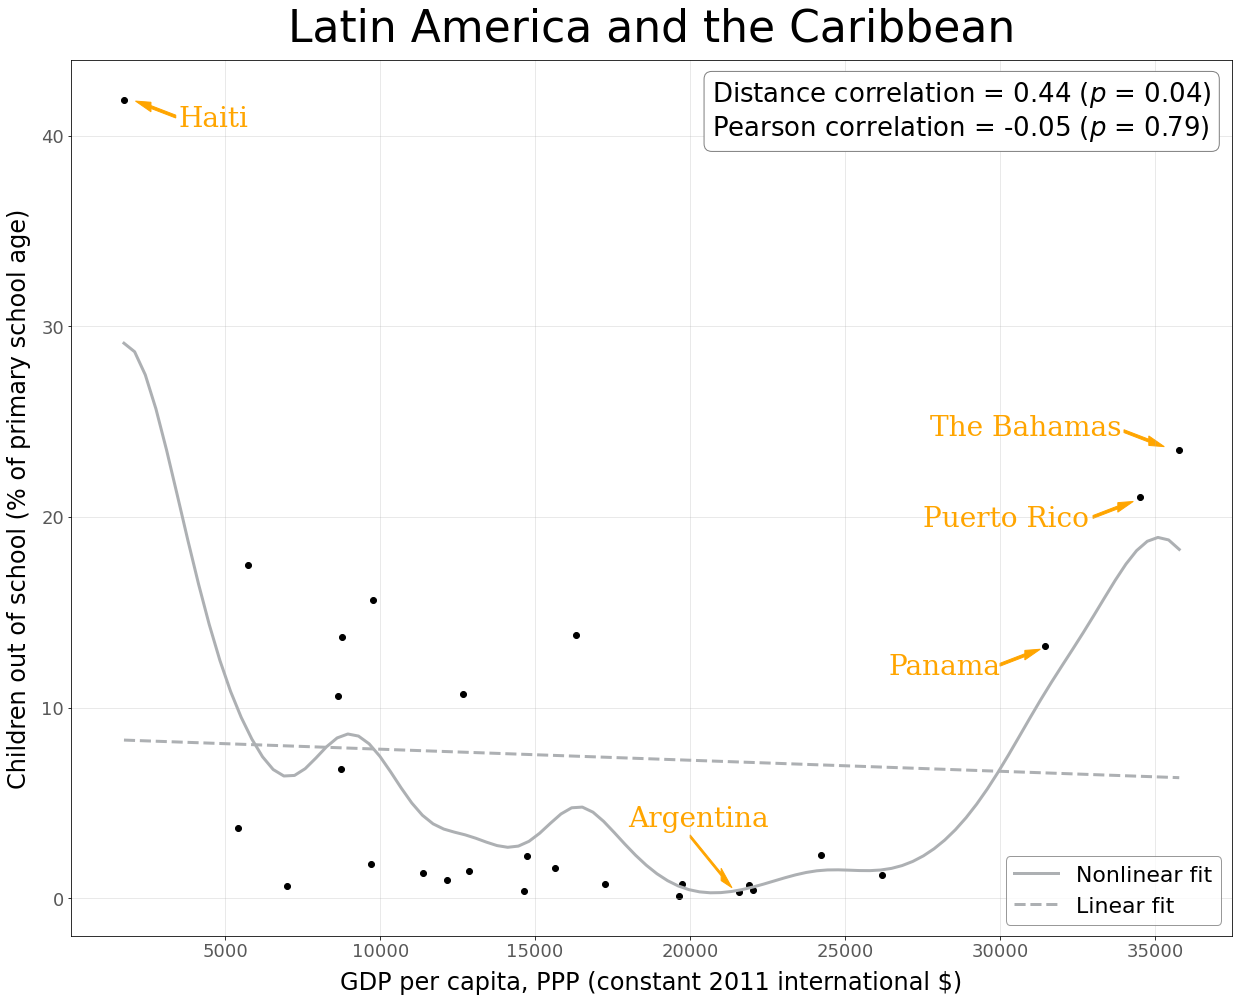

In [25]:
ind_0 = 'NY.GDP.PCAP.PP.KD' 
ind_1 = 'SE.PRM.UNER.ZS' 
group = 'Latin America and the Caribbean'
last_n = 0

print(info[info[0]==ind_0][3])
print(info[info[0]==ind_1][3])

x = []
y = []
for country in continents[group].dropna():
#for country in groups[group].dropna():
    if len(dict_all[country].loc[ind_0].dropna())>last_n and len(dict_all[country].loc[ind_1].dropna())>last_n:
        x.extend(dict_all[country].loc[ind_0].dropna().tail(last_n+1).to_list())
        y.extend(dict_all[country].loc[ind_1].dropna().tail(last_n+1).to_list())

if len(x)==0 or len(y)==0:
    pass
else:
    x = np.asarray(x).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
    
    d_cor = dcor.distance_correlation(x, y)
    d_cor_test = dcor.independence.distance_covariance_test(x, y, num_resamples=10000)

    p_cor = pearsonr(x.reshape(-1), y.reshape(-1))

    # plot x against y; each country is one data point
    plt.figure(figsize=(18,14))
    plt.scatter(x, y, c='k')
    
    # fitting non-linear function to data
    kernel = Matern(nu=2.5)
    #kernel = RBF(length_scale=1)
    gpr_x = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=0.435)
    gpr_x.fit(x, y)
    x_ = np.linspace(min(x), max(x), 100)
    y_mean_gpr, y_std_gpr = gpr_x.predict(x_, return_std=True)
    
    plt.plot(x_, y_mean_gpr, '#adb0b3', lw=3, ls='-', label='Nonlinear fit')
    #plt.fill_between(x_.flatten(), y_mean_gpr.flatten()-19.6*y_std_gpr.flatten(), y_mean_gpr.flatten()+19.6*y_std_gpr.flatten(), interpolate=True, alpha=0.25, color='#adb0b3')
    
    # fitting linear function to data
    linreg = LinearRegression()
    linreg.fit(x, y)
    y_mean_linreg = linreg.predict(x_)
    plt.plot(x_, y_mean_linreg, '#adb0b3', lw=3, ls='--', label='Linear fit')
    
    plt.xlabel(r'{}'.format(info[info[0]==ind_0][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.ylabel(r'{}'.format(info[info[0]==ind_1][2].to_list()[0]), fontsize=24, labelpad=10)
    plt.xticks(size=18, alpha=0.65)
    plt.yticks(size=18, alpha=0.65)
    plt.title('{}'.format(group), y=1.015, fontdict={'fontsize': 44})
    
    textstr = '\n'.join((
        'Distance correlation = %.2f ($p$ = %.2f)' % (d_cor, d_cor_test.p_value),
        'Pearson correlation = %.2f ($p$ = %.2f)' % (p_cor[0], p_cor[1])))
    props = dict(boxstyle='round', facecolor='white', edgecolor='grey')
    plt.text(20700, 40, textstr, fontsize=26, bbox=props)
    
    #x_arrow, y_arrow = 42, 53
    #plt.arrow(x_arrow, y_arrow, 1, 6, head_width=0.75, head_length=0.75, fc='#1b75bc', ec='#1b75bc', width=0.2)
    #plt.text(x_arrow-1, y_arrow-3, 'T', fontsize=28, c='#1b75bc', fontfamily='serif', fontweight='roman')
    
    x_arrow_c1, y_arrow_c1 = 3400, 41
    plt.arrow(x_arrow_c1, y_arrow_c1, -800, +0.5, head_width=0.5, head_length=500, fc='orange', ec='orange', width=0.15)
    plt.text(x_arrow_c1+100, y_arrow_c1-0.5, 'Haiti', fontsize=28, c='orange', fontfamily='serif', fontweight='roman')
    
    x_arrow_c2, y_arrow_c2 = 34000, 24.5
    plt.arrow(x_arrow_c2, y_arrow_c2, 800, -0.5, head_width=0.5, head_length=500, fc='orange', ec='orange', width=0.15)
    plt.text(x_arrow_c2-6250, y_arrow_c2-0.25, 'The Bahamas', fontsize=28, c='orange', fontfamily='serif', fontweight='roman')
    
    x_arrow_c3, y_arrow_c3 = 33000, 20
    plt.arrow(x_arrow_c3, y_arrow_c3, 800, 0.5, head_width=0.5, head_length=500, fc='orange', ec='orange', width=0.15)
    plt.text(x_arrow_c3-5500, y_arrow_c3-0.5, 'Puerto Rico', fontsize=28, c='orange', fontfamily='serif', fontweight='roman')
    
    x_arrow_c4, y_arrow_c4 = 20000, 3.25
    plt.arrow(x_arrow_c4, y_arrow_c4, 1000, -2, head_width=0.65, head_length=350, fc='orange', ec='orange', width=0.15)
    plt.text(x_arrow_c4-2000, y_arrow_c4+0.5, 'Argentina', fontsize=28, c='orange', fontfamily='serif', fontweight='roman')
    
    x_arrow_c5, y_arrow_c5 = 30000, 12.25
    plt.arrow(x_arrow_c5, y_arrow_c5, 800, 0.5, head_width=0.5, head_length=500, fc='orange', ec='orange', width=0.15)
    plt.text(x_arrow_c5-3600, y_arrow_c5-0.5, 'Panama', fontsize=28, c='orange', fontfamily='serif', fontweight='roman')
    
    plt.grid(alpha=0.35)
    plt.legend(loc=4, fontsize=22, edgecolor='grey')
    plt.tight_layout()
    plt.savefig('distance_cor/syn_tra_dependence_countries3.png', format='png')
    plt.show()

In [143]:
# countries at threshold
for country in continents[group].dropna():
    if dict_all[country].loc[ind_0].isnull().all()==False and dict_all[country].loc[ind_1].isnull().all()==False:
        print(country, dict_all[country].loc[ind_0][dict_all[country].loc[ind_0].last_valid_index()], dict_all[country].loc[ind_1][dict_all[country].loc[ind_1].last_valid_index()])

Antigua and Barbuda 21908.4585035162 0.6899
Bahamas, The 35782.7979039639 23.53087
Barbados 15638.8298973988 1.61179
Dominica 12155.558696274 0.95625
Grenada 17241.5319711333 0.76442
Haiti 1728.91006998723 41.88773
Jamaica 9761.49852210528 15.64909
Puerto Rico 34517.6132041046 21.02849
Trinidad and Tobago 26175.951728288 1.22018
Belize 7004.91230122915 0.66481
Costa Rica 19642.4178531668 0.11923
El Salvador 8775.98651978437 13.69967
Guatemala 8637.55532497518 10.62872
Honduras 5727.97357227863 17.46139
Mexico 19746.4356070408 0.72876
Nicaragua 5407.10470207971 3.68029
Panama 31458.6926255213 13.21826
Argentina 22033.9453093203 0.43269
Bolivia 8724.47574033647 6.78709
Brazil 14651.6161809346 0.38774
Chile 24226.1508878998 2.26992
Colombia 14730.8849270675 2.24193
Ecuador 11375.3311843291 1.31207
Guyana 9702.57885742106 1.79294
Paraguay 12684.5961910764 10.72262
Peru 12847.8852078957 1.41641
Suriname 16328.6861156777 13.82998
Uruguay 21561.0620529177 0.30549
